In [45]:
import numpy as np
import pandas as pd
import xarray as xr
import numba as nb
import dask

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping, StochasticWeightAveraging
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import ParameterSampler
from sklearn.utils import shuffle
import sklearn

from xgboost import XGBClassifier

from glob import glob
from tqdm import tqdm
import itertools 
import time
import os
import copy

from typing import Optional, List, Union
import logging
from IPython.utils import io

import spect

In [101]:
import imp
imp.reload(spect)

<module 'spect' from '/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/spect.py'>

# **Load and proprocess data**

In [219]:
BINS = np.arange(0, 1350, 50)
MZ_THRESH = 100

In [220]:
ds_bin = spect.get_binned_data(bins=BINS, mz_thresh=MZ_THRESH)

100%|███████████████████████████████████████████████████████████████████████████████| 1570/1570 [03:25<00:00,  7.64it/s]


In [221]:
ds_bin

<xarray.Dataset>
Dimensions:          (sample_id: 1570, mz: 101, temp_bins: 26, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * temp_bins        (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 5.543e-11 ... nan
    time             (sample_id, temp_bins) float64 61.56 266.8 ... nan nan
    temp             (sample_id, temp_bins) float64 40.9 74.9 122.9 ... nan nan
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... nan nan nan
    split            (sample_id) object 'train' 'train' ... 'test' 'test'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

In [222]:
ds_scale = ds_bin['abundance'].mean(dim=('temp_bins', 'mz')).groupby(ds_bin.instrument_type).mean()
missing_fill = -2

def preprocess(ds, drop_he=False, rebase=False, maxscale=True, scale_int=True, log_scale=False, nan_fill=missing_fill):
    ds_pro = ds.copy(deep=True)
    ds_pro['features'] = ds_pro['abundance'].clip(0, None)
    ds_pro['integrated_abundance'] = ds_pro['features'].mean(dim='temp_bins')
    if scale_int:
        ds_pro['integrated_abundance'] = (
            (ds_pro['integrated_abundance'].groupby(ds.instrument_type)/ds_scale)
            .drop('instrument_type')
        )
    if rebase:
        ds_pro['features'] = ds_pro.features - ds_pro.features.min(dim=('temp_bins'))
    if drop_he:
        ds_pro = ds_pro.drop_sel(mz=4)
    if maxscale:
        ds_pro['features'] = ds_pro.features/ds_pro.features.max(dim=('temp_bins', 'mz'))
    if log_scale:
        ds_pro['features'] = np.log10(ds_pro['features'].clip(1e-4,None))+3
        ds_pro['integrated_abundance'] = np.log10(ds_pro['integrated_abundance'].clip(1e-4,None))+3
    ds_pro = ds_pro.fillna(nan_fill)
    return ds_pro

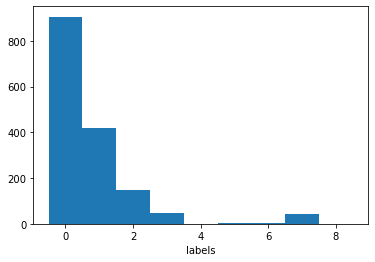

In [7]:
clip_n=9
ds_bin.labels.sum(dim='species').clip(0, clip_n).plot.hist(bins = np.arange(0,clip_n+1)-.5)
plt.show()

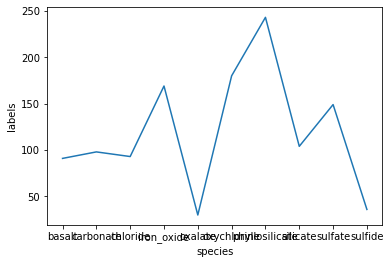

In [8]:
ds_bin.labels.sum(dim='sample_id').plot()

## Process data

In [9]:
from skmultilearn.model_selection import iterative_train_test_split

def base2_split(indices, y, splits):
    log2_splits = np.log2(splits)
    assert log2_splits==int(log2_splits)
    if log2_splits==1:
        indices_1, _, indices_2, _ = iterative_train_test_split(indices, y, test_size=0.5)
        return [indices_1, indices_2]
    else:
        indices_1, y_1, indices_2, y_2 = iterative_train_test_split(indices, y, test_size=0.5)
        return base2_split(indices_1, y_1, splits//2)+base2_split(indices_2, y_2, splits//2)

def cross_val_splits(ds, splits, random_seed=None):
    np.random.seed(random_seed)
    y = ds.labels.values
    indices = shuffle(ds.sample_id.values[:,None])
    partitions = base2_split(indices, y, splits=splits)
    ds_train_test = []
    for p in partitions:
        ds_train_test.append((ds.drop_sel(sample_id=p[:,0]), ds.sel(sample_id=p[:,0])))
    return ds_train_test

### Final dataset

In [223]:
ds_final = ds_bin.where(ds_bin.split=='train', drop=True)

ds_final

<xarray.Dataset>
Dimensions:          (sample_id: 766, temp_bins: 26, mz: 101, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S0764' 'S0765'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * temp_bins        (temp_bins) object (0, 50] (50, 100] ... (1250, 1300]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 5.543e-11 ... nan
    time             (sample_id, temp_bins) float64 61.56 266.8 ... nan nan
    temp             (sample_id, temp_bins) float64 40.9 74.9 122.9 ... nan nan
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    split            (sample_id) object 'train' 'train' ... 'train' 'train'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

In [224]:
def this_preprocess(ds):
    return preprocess(ds, drop_he=False, rebase=False, maxscale=True, scale_int=True, log_scale=True)

# **Model**

## Functions

In [177]:
class MZSequenceEmbedT(nn.Module):
    """Split image into mz sequences and embed them.
    Parameters
    ----------
    sequence_length : int
        Number of temperature bins.
    in_chans : int
        Number of input channels. 
    embed_dim : int
        The emmbedding dimension.
    Attributes
    ----------
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, sequence_length, in_chans=1, embed_dim=10):
        super().__init__()

        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=(sequence_length, 1),
                stride=(sequence_length, 1),
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, sequnce_length, mz_number)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, mz_number, embed_dim)`.
        """
        x = self.proj(x)  # (n_samples, embed_dim, 1, mz_number)
        x = torch.squeeze(x)  # (n_samples, embed_dim, mz_number)

        return x
    
class SequenceRefiner(nn.Module):
    def __init__(self, in_chans=10, out_chans=10, depth=1, dropout_p=0):
        super().__init__()
                
        refiner = []
        for i in range(depth):
            refiner += [
                nn.Conv1d(
                        in_chans,
                        in_chans,
                        kernel_size=1
                ),
                nn.BatchNorm1d(in_chans),
                nn.SELU(),
                nn.Dropout(p=dropout_p),
            ]
            
        self.refiner = nn.Sequential(*refiner)

        self.combiner = nn.Sequential(
            nn.Conv1d(
                in_chans,
                out_chans,
                kernel_size=1
            ),
            nn.BatchNorm1d(out_chans),
            nn.SELU(),
            nn.Dropout(p=dropout_p)
        )
            
    def forward(self, x):
        x_resid = x + self.refiner(x)
        x_resid = self.combiner(x_resid)
        return x_resid
    
class SequenceComparer(nn.Module):
    def __init__(self, n_sequences=10, sequence_dim=10, emb_dim=2, dropout_p=0):
        super().__init__()

        self.comparer = nn.Sequential(
            nn.Linear(n_sequences*sequence_dim, emb_dim),
            nn.BatchNorm1d(emb_dim),
            nn.SELU(),
            nn.Dropout(p=dropout_p)
        )
            
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.comparer(x)
        return x

In [178]:
class simpleModel(nn.Module):
    def __init__(self, 
                 sequence_length, 
                 mz_number, 
                 n_classes, 
                 in_chans=1, 
                 seq_embed_dim=10, 
                 seq_emb_depth=1, 
                 comp_embed_dim=10, 
                 dropout_p=0,
                 **kwargs,
                ):
        
        super().__init__()
        assert seq_emb_depth>=1
        
        sequence_embed = MZSequenceEmbedT(sequence_length, in_chans=in_chans, embed_dim=seq_embed_dim)
        
        sequence_refiners = [sequence_embed]
        for i in range(seq_emb_depth-1):
            sequence_refiners += [
                SequenceRefiner(
                    in_chans=seq_embed_dim, 
                    out_chans=seq_embed_dim, 
                    depth=2, 
                    dropout_p=dropout_p,
                )
            ]
            
        self.sequence_refiners = nn.ModuleList(sequence_refiners)
        
        sequence_comparers = []
        for i in range(seq_emb_depth):
            sequence_comparers += [
                SequenceComparer(
                    n_sequences=mz_number, 
                    sequence_dim=seq_embed_dim, 
                    emb_dim=comp_embed_dim, 
                    dropout_p=dropout_p,
                )
            ]
        self.sequence_comparers = nn.ModuleList(sequence_comparers)
        
        self.compare_aggregator = nn.Sequential(
            nn.Linear(seq_emb_depth*comp_embed_dim, n_classes)
        )
    
    def forward(self, x):
        comp_emb = []
        for ref, comp in zip(self.sequence_refiners, self.sequence_comparers):
            x = ref(x)
            comp_emb += [comp(x)]
        comp_emb = torch.cat(comp_emb, dim=1)
        return self.compare_aggregator(comp_emb)

In [179]:
class SimpleModelResidual(simpleModel):
    def __init__(self, 
                 previous_model,
                 eta,
                 sequence_length, 
                 mz_number, 
                 n_classes, 
                 in_chans=1, 
                 seq_embed_dim=10, 
                 seq_emb_depth=1, 
                 comp_embed_dim=10, 
                 dropout_p=0,
                 **kwargs):
        
        super().__init__(
                 sequence_length, 
                 mz_number, 
                 n_classes,
                 in_chans=in_chans, 
                 seq_embed_dim=seq_embed_dim, 
                 seq_emb_depth=seq_emb_depth, 
                 comp_embed_dim=comp_embed_dim, 
                 dropout_p=dropout_p,
                 **kwargs,
        )
        if previous_model is not None:
            for parameter in previous_model.parameters():
                parameter.requires_grad = False
        
        self.previous_model = previous_model
        self.eta = eta
        self.use_eta = False
        
    def forward(self,x):
        eta = self.eta if self.use_eta else 1
        if self.previous_model is None:
            return eta*super().forward(x)
        else:
            return self.previous_model(x) + eta*super().forward(x)
    


In [180]:
class SimpleModelLightning(pl.LightningModule):
    def __init__(
        self,
        previous_model = None,
        hparams: dict = {},
        model_params: dict = {},
    ):

        super().__init__()
        self.hparams.update(hparams)
        self.hparams.update(model_params)
        self.model_params = model_params
        self.save_hyperparameters()

        # optional modeling params
        self.patience = self.hparams.get("patience", 5)
        
        self.model = self._prepare_model(previous_model)
        self.seed = self.hparams.get("seed", 0)
        
        self.loss_fn = nn.BCEWithLogitsLoss()
        
    
    def forward(self, image: torch.Tensor):
        return self.model(image)

    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.
        """

        # Load images and labels
        x, y = batch

        # Forward pass
        preds = self.forward(x)

        # Log batch loss
        loss = self.loss_fn(preds, y)
                
        self.log("training_loss", loss, on_epoch=True, on_step=False)
            
        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        """
        Validation step.
        """
        
        # Load images and labels
        x, y = batch

        # Forward pass & softmax
        preds = self.forward(x)

        # Log batch IOU
        loss = self.loss_fn(preds, y)
        self.log("val_loss", loss) # mean automatically taken over validation set 

        return


    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.model.parameters(), lr=self.hparams["lr"], amsgrad=True)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
            factor=0.5,
            patience=self.patience,
            threshold=2e-4,
            cooldown=self.patience//2,                                   
        )
        sch = {"scheduler": sch, "monitor": "training_loss"}
        return [opt], [sch]
        

    def _prepare_model(self, previous_model):
        model = SimpleModelResidual(            
            previous_model=previous_model,
            **self.model_params,
        )
        return model

In [181]:
def split_version(s):
    s = s.split('/version_')
    return s[0]+"/version_"+s[1].split('/')[0]


def score_model(model, dataloader):
    loss_fn = nn.BCEWithLogitsLoss()
    ls = []
    for X,y in dataloader:
        X = X.to("cuda:0")
        y = y.to("cuda:0")
        y_pred = model(X)
        ls.append(loss_fn(y_pred, y).item())
    return np.mean(ls)
                       

class GBNet(nn.Module):
    def __init__(self,
            n_estimators,
            est_patience: int = 2,
            hparams: dict = {},
            model_params: dict = {},
            
            ):
        super().__init__()
        self.n_estimators = n_estimators
        self.est_patience = est_patience
        self.model_params = model_params
        self.hparams = hparams
        
        self.scores = []
        self.checkpoint_paths = []
        self.best_checkpoint = None
        self.best_score = np.inf
        
        self.model = None
        self.best_model = None
        
    
    def _fit_estimator(self, ds_train, ds_val):
        pl_loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if 'pytorch_lightning' in name]
        for l in pl_loggers: 
            l.propagate = False

        model = SimpleModelLightning(
            previous_model=self.model,
            hparams=dict(
                lr=self.hparams.get('lr', 1e-3), 
                patience=self.hparams.get('patience', 10),
            ),
            model_params = dict(
                sequence_length=len(ds_train.temp_bins),
                mz_number=len(ds_train.mz),
                n_classes=len(ds_train.species),
                **self.model_params
            )
        )

        datamodule = spect.SpectroDataModule(
            ds_train,
            ds_val=ds_val,
            num_workers=4,
            batch_size=16,
            data_split_seed=34536,
            val_frac=0.1,
        )


        model_checkpoint = ModelCheckpoint(
            monitor="val_loss", 
            mode="min",
            verbose=True,
            save_top_k=1,
            save_last=False,
        )
        
        early_stop_callback = EarlyStopping(
            monitor="val_loss", 
            min_delta=0.00, 
            patience=self.hparams.get('patience', 10)*8, 
            verbose=False, 
            mode="min",
        )

        callbacks = [model_checkpoint, early_stop_callback, LearningRateMonitor()]


        logger = TensorBoardLogger('../lightning_logs', name=self.hparams.get('logdir', 'GBNet'))

        # train
        trainer = pl.Trainer(
            gpus=[0],
            fast_dev_run=False,
            log_every_n_steps=50,
            default_root_dir='../.',
            callbacks = callbacks,
            max_epochs=self.hparams.get('n_epochs', 250),
            logger=logger,
            accumulate_grad_batches=1,
            val_check_interval=1.0,
            reload_dataloaders_every_n_epochs=1,
            enable_model_summary=False,
            enable_progress_bar=False,
        )

        with io.capture_output() as captured:
            trainer.fit(model, datamodule=datamodule)

        model = SimpleModelLightning.load_from_checkpoint(model_checkpoint.best_model_path).model
        model = model.to("cuda:0")
        
        model.eval()
        model.use_eta = True
             
        train_score = score_model(model, datamodule.train_dataloader())
        val_score = score_model(model, datamodule.val_dataloader())
                
        model_path = model_checkpoint.best_model_path
        return model, model_path, train_score, val_score
        
    def fit(self, ds_train, ds_val, keep_clean=2):
        waiting = 0
        pbar = tqdm(range(self.n_estimators), desc='Fitting NN')
        for n in pbar:
            waiting += 1
            self.model, checkpoint_path, train_score, val_score = self._fit_estimator(ds_train, ds_val)
            pbar.set_postfix({'train_loss': train_score, 'val_loss': val_score})
            self.scores += [val_score]
            self.checkpoint_paths += [checkpoint_path]
            if val_score<self.best_score:
                if self.best_checkpoint is not None:
                    if keep_clean>0:
                        os.system(f"rm {self.best_checkpoint}")
                    if keep_clean>1:
                        os.system(f"rm -r {split_version(self.best_checkpoint)}")
                self.best_checkpoint = checkpoint_path
                self.best_score = val_score
                self.best_model = self.model.to("cuda:0")
                waiting = 0
            if waiting>self.est_patience:
                return self
        return self
    
    def forward(self, x):
        self.best_model = self.best_model.to("cuda:0")
        return self.best_model.forward(x)

```
ds_train_test_splits = cross_val_splits(this_preprocess(ds_final), 8, random_seed=317984)

gbnets = []
for i, split in enumerate(ds_train_test_splits):
    this_gbnet = GBNet(
        n_estimators=10,
        est_patience=np.inf,
        hparams=dict(
            patience=10,
            lr=1e-4,
            logdir=f"test_{i}",
            n_epochs=5,
        ),
        model_params=dict(
            eta=0.2,
            seq_embed_dim=16, 
            seq_emb_depth=2, 
            comp_embed_dim=32, 
            dropout_p=0.1,
        ),
    )
    this_gbnet.fit(*split, keep_clean=1)
    gbnets += [this_gbnet]
```

This taskes some time and is no longer the main aim of this notebook. Plus in the next section we do this indirectly by fitting boosted NN+XGB models. You can see the performance of the NN alone in that.

In [225]:
default_net_params = dict(
    n_estimators = 10,
    est_patience = np.inf,
    hparams = dict(
        patience = 10,
        lr = 1e-4,
        logdir = "default",
        n_epochs=250,
    ),
    model_params = dict(
        eta = 0.5,
        seq_embed_dim = 16, 
        seq_emb_depth = 2, 
        comp_embed_dim = 32, 
        dropout_p = 0.1,
    ),
)

default_xgboost_params = dict(
    est_patience=10,
    model_params = dict(
        min_child_weight = 2,
        gamma = .1,
        subsample = 0.9,
        colsample_bytree = 0.9,
        reg_alpha = 0.01,
        max_depth = 6,
        learning_rate = 0.05,
        n_estimators = 500,
        max_delta_step = 1,
        scale_pos_weight = 8,
    ),
)


class StackedXGNet:
    def __init__(self,
            net_params=default_net_params,
            xgboost_params=default_xgboost_params,
            ):
        
        self.net = GBNet(**net_params)
        
        self._single_xgboost = XGBClassifier(
            n_jobs=20,
            eval_metric='logloss',
            gpu_id=0,
            use_label_encoder=False,
            missing=missing_fill,
            tree_method='exact',
            **xgboost_params['model_params']
        )
        
        self.net_params = net_params
        self.xgboost_params = xgboost_params
        
        self.xgboost = []
        self.logloss_report = None
    
    def _prepare_data_xgboost(self, ds, get_y=True):
        X = [
            ds.features.stack(dict(z=("temp_bins","mz"))).values, 
            (ds.instrument_type.values=='commercial').astype(float)[:, None],
            ds.integrated_abundance.values,
            ds.time.values,
        ]
        X = np.concatenate(X, axis=1)
        
        if get_y:
            y = ds.labels.values
            return X, y
        else:
            return X
        
    
    def _fit_xgboost(self, ds_train, ds_val):
        
        X_train, y_train_all = self._prepare_data_xgboost(ds_train)
        X_val, y_val_all = self._prepare_data_xgboost(ds_val)
        base_margin_train_all = self._predict_net(ds_train)
        base_margin_val_all = self._predict_net(ds_val)
        
        for col in tqdm(range(y_train_all.shape[1]), desc='Fitting xgboost'):
            y_train = y_train_all[:, col]
            y_val = y_val_all[:, col]
            base_margin_train = base_margin_train_all[:, col]
            base_margin_val = base_margin_val_all[:, col]

            this_clf = sklearn.base.clone(self._single_xgboost)
            
            this_clf.fit(
                X_train, 
                y_train,
                base_margin=base_margin_train,
                eval_set=((X_train, y_train), (X_val, y_val),),
                base_margin_eval_set=(base_margin_train, base_margin_val),
                early_stopping_rounds=self.xgboost_params['est_patience'], ##### TODO
                eval_metric="logloss",
                verbose=0
                          
            )
            
            self.xgboost.append(this_clf)

        return
    
    def fit(self, ds_train, ds_val, keep_clean=2):
        # fit the net
        self.species = ds_train.species.values
        self.net.fit(ds_train, ds_val, keep_clean=keep_clean)
        self._fit_xgboost(ds_train, ds_val)
        self.logloss_report = self.estimate_logloss(ds_train, ds_val)
        
    def _predict_net(self, ds, batch_size=16, num_workers=4):
        dataloader = torch.utils.data.DataLoader(
            spect.SpectroDataset(ds, get_y=False),
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            pin_memory=True,
        )
        y_preds = []
        with torch.no_grad():
            for X in dataloader:
                y_preds += [self.net(X.to("cuda:0")).cpu().numpy()]
        return np.concatenate(y_preds, axis=0)
    
    def _predict_proba(self, ds, batch_size=16, num_workers=4):
        X = self._prepare_data_xgboost(ds, get_y=False)
        base_margin_all = self._predict_net(ds, batch_size=batch_size, num_workers=num_workers)

        y_preds = []
        for col in range(base_margin_all.shape[1]):
            y_preds += [self.xgboost[col].predict_proba(X, base_margin=base_margin_all[:, col])[:, 1:]]
        return np.concatenate(y_preds, axis=1)
    
    def predict_net(self, ds, apply_sigmoid=True, batch_size=16, num_workers=4):
        y_preds = self._predict_net(ds, batch_size=batch_size, num_workers=num_workers)
        if apply_sigmoid:
            y_preds = (1 + np.exp(-y_preds))**-1
        ds_pred = xr.DataArray(
            y_preds, 
            dims=['sample_id', 'species'], 
            coords=[ds.sample_id.values, self.species], 
            name='net_preds'
        )
        return ds_pred
    
    def predict_proba(self, ds, batch_size=16, num_workers=4):
        y_preds = self._predict_proba(ds, batch_size=batch_size, num_workers=num_workers)
        ds_pred = xr.DataArray(
            y_preds, 
            dims=['sample_id', 'species'], 
            coords=[ds.sample_id.values, self.species], 
            name='preds'
        )
        return ds_pred
    
    def estimate_logloss(self, ds_train, ds_val):
        net_train = xr_loss(self.predict_net(ds_train), ds_train.labels)
        net_val = xr_loss(self.predict_net(ds_val), ds_val.labels)
        boosted_train = xr_loss(self.predict_proba(ds_train), ds_train.labels)
        boosted_val = xr_loss(self.predict_proba(ds_val), ds_val.labels)
        
        losses = xr.merge([
            net_train.to_dataset(name='net_train'),
            net_val.to_dataset(name='net_val'),
            boosted_train.to_dataset(name='boosted_train'),
            boosted_val.to_dataset(name='boosted_val'),
        ])
        return losses
    
def xr_loss(ds_pred, ds_target):
    return -(ds_target*np.log(ds_pred)+(1-ds_target)*np.log(1-ds_pred)).mean(dim=('sample_id'))

In [226]:
ds_train_test_splits = cross_val_splits(this_preprocess(ds_final), 8, random_seed=317984)

In [227]:
def tprint(s):
    print(f"{time.asctime()} - {s}")

In [ ]:
cross_val_results = []
for i, split in enumerate(ds_train_test_splits):
    #if i==0: continue
    tprint(f'Split {i+1} of {len(ds_train_test_splits)}')
    
    net_params = copy.deepcopy(default_net_params)
    net_params['hparams']['logdir'] = f"stackedxgnet_cv_{i}"
    net_params['est_patience'] = 3
    
    boostednet = StackedXGNet(net_params=net_params)
    boostednet.fit(*split, keep_clean=1)
    
    cross_val_results.append(boostednet)

Thu Mar 17 09:15:17 2022 - Split 1 of 8


Fitting xgboost: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


Thu Mar 17 09:41:03 2022 - Split 2 of 8


Fitting xgboost: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


Thu Mar 17 09:58:41 2022 - Split 3 of 8


Fitting NN:  50%|██████████████████                  | 5/10 [15:18<14:53, 178.61s/it, train_loss=0.0958, val_loss=0.153]

## Losses

In [232]:
losses = xr.merge([r.logloss_report.expand_dims(dim='split', axis=1).assign_coords(split=[i]) for i, r in enumerate(cross_val_results)])
losses.mean(dim=('split', 'species'))

<xarray.Dataset>
Dimensions:        ()
Data variables:
    net_train      float64 0.1011
    net_val        float64 0.1855
    boosted_train  float64 0.06948
    boosted_val    float64 0.1647

In [ ]:
losses.mean(dim='split')

In [ ]:
losses.mean(dim='species')

In [195]:
losses

<xarray.Dataset>
Dimensions:        (split: 8, species: 10)
Coordinates:
  * split          (split) int64 0 1 2 3 4 5 6 7
  * species        (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    net_train      (species, split) float64 0.1225 0.1243 ... 0.05556 0.02313
    net_val        (species, split) float64 0.1764 0.3077 ... 0.07103 0.07156
    boosted_train  (species, split) float64 0.02007 0.1038 ... 0.006061 0.004627
    boosted_val    (species, split) float64 0.1149 0.3024 ... 0.01679 0.02523

## Analysis

In [196]:
preds_list = [ds_val.merge(model.predict_proba(ds_val)) for model, (_, ds_val) in zip(cross_val_results, ds_train_test_splits)]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2dea47170>
Traceback (most recent call last):
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Traceback (most recent call last):
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2

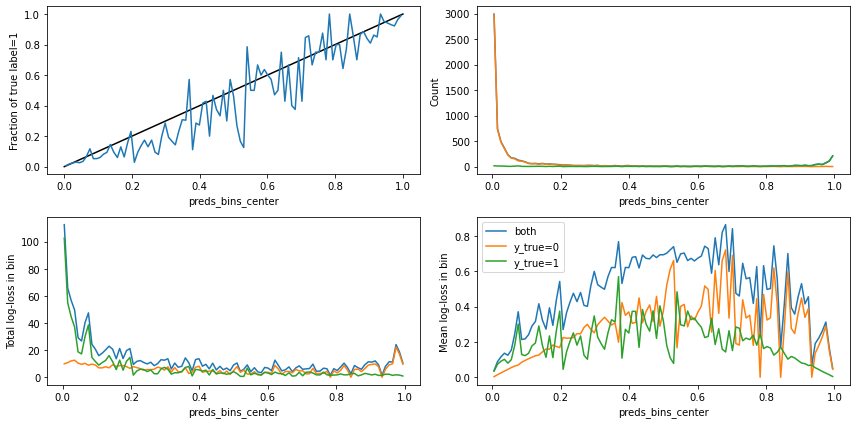

In [197]:
def all_log_loss(yt, yp):
    return -(yt*np.log(yp)+(1-yt)*np.log(1-yp))

pred_bins = np.linspace(0,1,100)

fig, axes = plt.subplots(2,2, figsize=(12,6))
ds = xr.merge(preds_list)
ax = axes[0, 0]
ax.plot([0,1], [0,1], color='k')
ds.groupby_bins(ds.preds, pred_bins).mean().labels.plot(ax=ax)
ax.set_ylabel('Fraction of true label=1')

ax = axes[0, 1]
ds.groupby_bins(ds.preds, pred_bins).count().labels.plot(ax=ax, label='both')
ds.where(ds.labels==0).groupby_bins(ds.preds, pred_bins).count().labels.plot(ax=ax, label='y_true=0')
ds.where(ds.labels==1).groupby_bins(ds.preds, pred_bins).count().labels.plot(ax=ax, label='y_true=0')
ax.set_ylabel('Count')

ax = axes[1, 0]
x = all_log_loss(ds.labels, ds.preds.clip(0.0, None))
x.groupby_bins(ds.preds, pred_bins).sum().plot(ax=ax, label='both')
x.where(ds.labels==0).groupby_bins(ds.preds, pred_bins).sum().plot(ax=ax, label='y_true=0')
x.where(ds.labels==1).groupby_bins(ds.preds, pred_bins).sum().plot(ax=ax, label='y_true=1')
ax.set_ylabel('Total log-loss in bin')

ax = axes[1, 1]
x.groupby_bins(ds.preds, pred_bins).mean().plot(ax=ax, label='both')
x.where(ds.labels==0).fillna(0).groupby_bins(ds.preds, pred_bins).mean().plot(ax=ax, label='y_true=0')
x.where(ds.labels==1).fillna(0).groupby_bins(ds.preds, pred_bins).mean().plot(ax=ax, label='y_true=1')
ax.set_ylabel('Mean log-loss in bin')
ax.legend()

plt.tight_layout()
plt.show()

Most error comes from false negatives

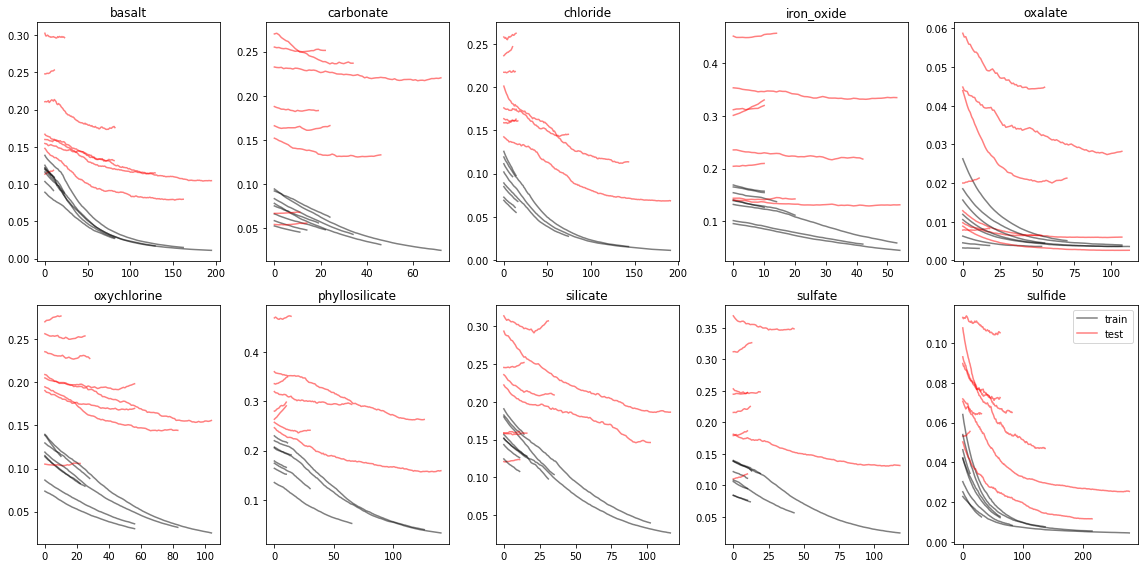

In [198]:
def plot_learning_curve(model, ax=None, add_label=False):
    if ax is None:
        ax = plt.subplot(111)
    results = model.evals_result()
    ax.plot(results['validation_0']['logloss'], label='train' if add_label else None, color='k', alpha=.5)
    ax.plot(results['validation_1']['logloss'], label='test' if add_label else None, color='r', alpha=.5)
    return ax

fig, axes = plt.subplots(2, 5, figsize=(16,8))
for j, (ax, species) in enumerate(zip(axes.flatten(), ds_final.species.values)):
    for i, model in enumerate(cross_val_results):
        plot_learning_curve(model.xgboost[j], ax=ax, add_label=i==0)
    ax.set_title(species)
    
plt.tight_layout()
ax.legend()
plt.show()

## Try adding sudo labelling

In [ ]:
ds_sup = spect.supplementary_get_binned_data()

In [ ]:
ds_sup = this_preprocess(ds_sup)

In [215]:
sup_probs = []
for model in cross_val_results:
    sup_probs += [model.predict_proba(ds_sup)]

sup_preds = xr.merge([pred.expand_dims(dim='split', axis=1).assign_coords(split=[i]) for i, pred in enumerate(sup_probs)])

sup_pred_mean = sup_preds.preds.mean(dim='split')
sup_pred_std = sup_preds.preds.std(dim='split')
mask = (sup_pred_std<0.2).all(dim='species')

ds_sudo = ds_sup
ds_sudo['labels'] = (sup_pred_mean>0.5).astype(float)
ds_sudo = ds_sudo.where(mask, drop=True)

In [ ]:
mask.sum()

In [ ]:
cross_val_sudo_results = []
for i, (ds_train, ds_val) in enumerate(ds_train_test_splits):
    tprint(f'Split {i+1} of {len(ds_train_test_splits)}')
    
    ds_train = xr.concat([ds_train, ds_sudo], dim='sample_id')
    net_params = copy.deepcopy(default_net_params)
    net_params['hparams']['logdir'] =  f"stackedxgnet_sudo_cv_{i}"
    #net_params['hparams']['n_epochs'] = 5
    net_params['est_patience'] = 3
    
    boostednet = StackedXGNet(net_params=net_params)
    boostednet.fit(ds_train, ds_val, keep_clean=1)
    
    cross_val_sudo_results.append(boostednet)

In [199]:
sudo_losses = xr.merge([r.logloss_report.expand_dims(dim='split', axis=1).assign_coords(split=[i]) for i, r in enumerate(cross_val_sudo_results)])
sudo_losses.mean(dim=('split', 'species'))

<xarray.Dataset>
Dimensions:        ()
Data variables:
    net_train      float64 0.4284
    net_val        float64 0.471
    boosted_train  float64 0.06096
    boosted_val    float64 0.1836